In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import random
import openpyxl
import math
import statistics as stats
import shlex
import time
import os

import matplotlib.pyplot as plt

In [2]:
wb_obj = openpyxl.load_workbook('hPPIN_network.xlsx') 
sheet = wb_obj.active

hPPIN = nx.Graph()
for row in sheet.iter_rows(2, sheet.max_row):
    node1 = row[0].value
    node2 = row[1].value
    hPPIN.add_edge(node1, node2, weight=1)
len(list(hPPIN.nodes))

17061

In [3]:
print(nx.info(hPPIN))

Graph with 17061 nodes and 188495 edges


/tmp/ipykernel_1378/2831221079.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(hPPIN))


In [5]:
(2*len(hPPIN.edges))/(len(hPPIN.nodes)*(len(hPPIN.nodes) - 1))

0.0012952282867770587

In [3]:
textfile = open("hPPIN_degree_list.txt", "w")

for (node, val) in hPPIN.degree():

    textfile.write(node + "\t" + str(val) + "\n")

textfile.close()

In [4]:
G = nx.Graph()
#  give filename
file2 = "STRING_db_list.txt"

# create dictionary
string_db = {}
with open(file2) as IN:
    for line in IN:
        ensembl = line.rstrip().split("\t")[0]
        gene_name = line.rstrip().split("\t")[1]

        string_db[ensembl] = gene_name

        
#  give filename
file3 = "string_network_no_scores.txt"

with open(file3) as IN:
    for line in IN:
        node1 = line.rstrip().split("\t")[0]
        node2 = line.rstrip().split("\t")[1]
        score = 1

        node1_translated = string_db[node1]
        node2_translated = string_db[node2]

        G.add_edge(node1_translated, node2_translated, weight=score)

In [5]:
textfile = open("STRING_NS_degree_list.txt", "w")

for (node, val) in G.degree():

    textfile.write(node + "\t" + str(val) + "\n")

textfile.close()

In [6]:
G = nx.Graph()
#  give filename
file2 = "STRING_db_list.txt"

# create dictionary
string_db = {}
with open(file2) as IN:
    for line in IN:
        ensembl = line.rstrip().split("\t")[0]
        gene_name = line.rstrip().split("\t")[1]

        string_db[ensembl] = gene_name
        
#  give filename
file3 = "string_network_scores.txt"

with open(file3) as IN:
    for line in IN:
        node1 = line.rstrip().split("\t")[0]
        node2 = line.rstrip().split("\t")[1]
        score = int(line.rstrip().split("\t")[2])

        node1_translated = string_db[node1]
        node2_translated = string_db[node2]

        G.add_edge(node1_translated, node2_translated, weight=score)

        
textfile = open("STRING_degree_list.txt", "w")

for (node, val) in G.degree():

    textfile.write(node + "\t" + str(val) + "\n")

textfile.close()

In [5]:
def list_contains(List1, List2): 
    check = []
  
    # add elements in list 1 that are in list2
    for m in List1: 
        if (m in List2) & (not (m in check)): 
            check.append(m)
            
    return check

In [83]:
def get_matched_controls(G, genes, sample):
    # only genes in the PPI
    file_genes = pd.read_csv(genes, header = None, names = ['genes'])
    node_list = list(G.nodes)
    gene_list = list_contains(file_genes['genes'], node_list)
    
    # get degrees and repeatsfor each
    gene_list_degrees = [val for (node, val) in hPPIN.degree(gene_list)]
    degree_repeats = dict((i, gene_list_degrees.count(i)) for i in gene_list_degrees)

    # extract  n fold nodes with the same degree
    matched_controls = []
    for (degree, repeat) in degree_repeats.items():
        controls = [node for (node, val) in hPPIN.degree() if val == degree]
        controls = [x for x in controls if x not in gene_list]
        if len(controls) > (sample*repeat):
            matched_controls.extend(random.sample(controls, sample*repeat))
        else:
            matched_controls.extend(controls)
    
    print("Total Genes: " + str(len(file_genes)))
    print("Total Genes in PPI: " + str(len(gene_list)))
    print("Expected Matched Controls: " + str(sample*len(gene_list)))
    print("Actual Matched Controls: " + str(len(matched_controls)))
    print("")
    print("Mean degree in set: " + str(stats.mean([val for (node, val) in hPPIN.degree(gene_list)])))
    print("Mean degree in matched set: " + str(stats.mean([val for (node, val) in hPPIN.degree(matched_controls)])))
    print("Mean degree in PPI network: " + str(stats.mean([val for (node, val) in hPPIN.degree()])))
    print("")
    
    gene_list_degree = [val for (node, val) in hPPIN.degree(gene_list)]
    matched_list_degree = [val for (node, val) in hPPIN.degree(matched_controls)]
    return([matched_controls,gene_list,
            gene_list_degree,
            matched_list_degree,
            stats.mean([val for (node, val) in hPPIN.degree(gene_list)]),
            stats.mean([val for (node, val) in hPPIN.degree(matched_controls)])])

In [97]:
cancer_driver_matched = get_matched_controls(hPPIN, "cosmic_hallmarks.txt",1)

Total Genes: 723
Total Genes in PPI: 679
Expected Matched Controls: 679
Actual Matched Controls: 639

Mean degree in set: 73.6082474226804
Mean degree in matched set: 51.75430359937402
Mean degree in PPI network: 22.096594572416624



In [99]:
stats.mean(cancer_driver_matched[2])

73.6082474226804

In [81]:
out_list = cancer_driver_matched[0]

textfile = open("cosmic_driver_matched.txt", "w")

for element in out_list:

    textfile.write(element + "\n")

textfile.close()

<AxesSubplot:xlabel='Group', ylabel='value'>

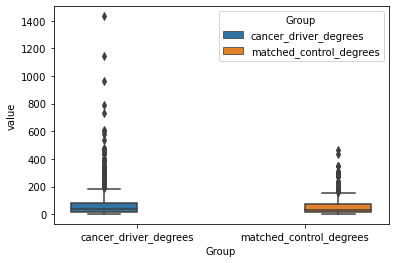

In [54]:
df = pd.DataFrame({'Group': group, 'Degrees': degrees})

import matplotlib.pyplot as plt
import seaborn as sns

dd=pd.melt(df,id_vars=['Group'],value_vars=['Degrees'],var_name='Degrees')
sns.boxplot(x='Group',y='value',data=dd,hue='Group')

In [49]:
group = ['cancer_driver_degrees'] * len(cancer_driver_matched[2]) + ['matched_control_degrees'] * len(cancer_driver_matched[3])
degrees = cancer_driver_matched[2] + cancer_driver_matched[3]

In [103]:
degrees = [val for (node, val) in hPPIN.degree()]
group = ["hPPin_total"]*len(degrees)
degree_mean_actual = []
degree_mean_matched = []
for file in os.listdir("/data/timonaj/cancer_as_wound/ppi_analysis/total_spec_exp_genes/"):
    print("#################################################")
    print(file)
    input_str = "/data/timonaj/cancer_as_wound/ppi_analysis/total_spec_exp_genes/" + file
    output_list = get_matched_controls(hPPIN, input_str, 1)
    
    group = group + ([file[:-4]]*len(output_list[2]))
    degrees = degrees + output_list[2]
    print(stats.mean(output_list[2]))
    
    degree_mean_actual.append(output_list[4])
    
    degree_mean_matched.append(output_list[5])

#################################################
sscrofa_wound_down.txt
Total Genes: 500
Total Genes in PPI: 464
Expected Matched Controls: 464
Actual Matched Controls: 454

Mean degree in set: 44.73922413793103
Mean degree in matched set: 39.279735682819386
Mean degree in PPI network: 22.096594572416624

44.73922413793103
#################################################
mmusculus_stress_down.txt
Total Genes: 500
Total Genes in PPI: 408
Expected Matched Controls: 408
Actual Matched Controls: 406

Mean degree in set: 22.985294117647058
Mean degree in matched set: 21.89408866995074
Mean degree in PPI network: 22.096594572416624

22.985294117647058
#################################################
hsapiens_regen_up.txt
Total Genes: 426
Total Genes in PPI: 370
Expected Matched Controls: 370
Actual Matched Controls: 366

Mean degree in set: 27.232432432432432
Mean degree in matched set: 24.191256830601095
Mean degree in PPI network: 22.096594572416624

27.232432432432432
#################

[Text(0, 0, 'hPPin_total'),
 Text(1, 0, 'sscrofa_wound_down'),
 Text(2, 0, 'mmusculus_stress_down'),
 Text(3, 0, 'hsapiens_regen_up'),
 Text(4, 0, 'celegans_stress_up'),
 Text(5, 0, 'amexicanum_regen_down'),
 Text(6, 0, 'cosmic_hallmarks'),
 Text(7, 0, 'dmelanogaster_wound_down'),
 Text(8, 0, 'dmelanogaster_wound_up'),
 Text(9, 0, 'rnorvegicus_wound_down'),
 Text(10, 0, 'drerio_regen_down'),
 Text(11, 0, 'mmusculus_stress_up'),
 Text(12, 0, 'hsapiens_regen_down'),
 Text(13, 0, 'hsapiens_wound_up'),
 Text(14, 0, 'clupisFamiliaris_wound_down'),
 Text(15, 0, 'clupisFamiliaris_wound_up'),
 Text(16, 0, 'rnorvegicus_wound_up'),
 Text(17, 0, 'hsapiens_wound_down'),
 Text(18, 0, 'dmelanogaster_stress_down'),
 Text(19, 0, 'celegans_stress_down'),
 Text(20, 0, 'sscrofa_wound_up'),
 Text(21, 0, 'drerio_regen_up'),
 Text(22, 0, 'hsapiens_stress_up'),
 Text(23, 0, 'dmelanogaster_stress_up'),
 Text(24, 0, 'hsapiens_stress_down'),
 Text(25, 0, 'amexicanum_regen_up')]

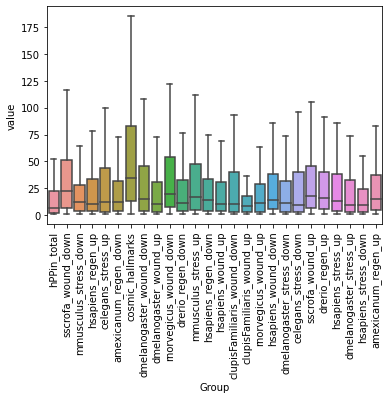

In [96]:
df = pd.DataFrame({'Group': group, 'Degrees': degrees})

import matplotlib.pyplot as plt
import seaborn as sns

dd=pd.melt(df,id_vars=['Group'],value_vars=['Degrees'],var_name='Degrees')
plot = sns.boxplot(x='Group',y='value',data=dd,showfliers = False)
plot.set_xticklabels(plot.get_xticklabels(),rotation = 90)

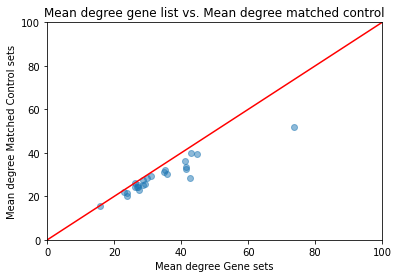

In [105]:
# degree matching
plt.scatter(degree_mean_actual, degree_mean_matched, alpha=0.5)
plt.xlim((0, 100)) # restricts x axis from 0 to 25
plt.ylim((0, 100)) # restricts x axis from 0 to 25
plt.plot([0, 100], [0, 100], color="red") # plots line y = x
plt.title('Mean degree gene list vs. Mean degree matched control')
plt.xlabel('Mean degree Gene sets')
plt.ylabel('Mean degree Matched Control sets')
plt.show()